#Assignment 3: Deep Learning Using Keras

Due: Novemer 15th, 2022

Number of late days used: 2

Members: Myanh Tran, Enrique Cardenas III

##Introduction to dataset




- Dog-breed recognization using images from ImageNet and CNN techniques
- Inspired from
[link text](https://www.kaggle.com/c/dog-breed-identification)
- Data source from [link text](http://vision.stanford.edu/aditya86/ImageNetDogs/)

##Read in data

In [ ]:
#import libraries
import os, gc, glob, cv2, PIL, PIL.Image, pathlib, tarfile, random, datetime
random.seed(24)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path
from zipfile import ZipFile
from google.colab import files
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from IPython.display import display, Image



---

https://www.kaggle.com/code/mrdbourke/tensorflow-2-x-tensorflow-hub-end-to-end-example/notebook

##Get file by Box and then unzip

In [ ]:
!wget https://utdallas.box.com/shared/static/4jiltaslzgys29r5487gg4iqiomrkk1j.zip

--2022-11-17 19:53:44--  https://utdallas.box.com/shared/static/4jiltaslzgys29r5487gg4iqiomrkk1j.zip
Resolving utdallas.box.com (utdallas.box.com)... 74.112.186.144
Connecting to utdallas.box.com (utdallas.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/4jiltaslzgys29r5487gg4iqiomrkk1j.zip [following]
--2022-11-17 19:53:44--  https://utdallas.box.com/public/static/4jiltaslzgys29r5487gg4iqiomrkk1j.zip
Reusing existing connection to utdallas.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://utdallas.app.box.com/public/static/4jiltaslzgys29r5487gg4iqiomrkk1j.zip [following]
--2022-11-17 19:53:44--  https://utdallas.app.box.com/public/static/4jiltaslzgys29r5487gg4iqiomrkk1j.zip
Resolving utdallas.app.box.com (utdallas.app.box.com)... 74.112.186.144
Connecting to utdallas.app.box.com (utdallas.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting 

When mode is 'r', metadata_encoding may be set to the name of a codec, which will be used to decode metadata such as the names of members and ZIP comments.

If the file is created with mode 'w', 'x' or 'a' and then closed without adding any files to the archive, the appropriate ZIP structures for an empty archive will be written to the file.

https://docs.python.org/3/library/zipfile.html#zipfile.BadZipFile



In [ ]:
#get train and test file from Zip file
file_name = '/content/4jiltaslzgys29r5487gg4iqiomrkk1j.zip'
with ZipFile(file_name, 'r') as zips: zips.extractall()

In [ ]:
breeds = pd.read_csv('https://utdallas.box.com/shared/static/iw1uicp7lm5z0wdyp22yl8uze513tssv.csv') #read in dog breed csv 'labels'
breeds.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


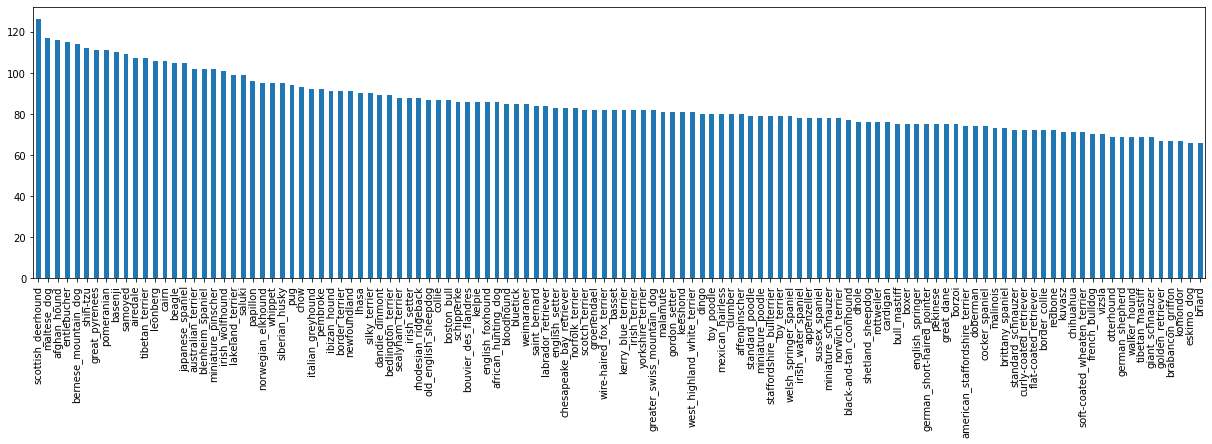

In [ ]:
#quick visualization of distribution across breed. Pay attention to potential class dis-balance.
breeds['breed'].value_counts().plot.bar(figsize = (21,5))

Scottish deerhound has the most images to train with about 125 images. Meanwhile, briard has about 70 images to train. The rest is in a good range from 120 to 70. Each class has collectively each images to train

##Load train and test data from file

In [ ]:
#load train data
train_data_path = '/content/train/' #make path of train file
file_paths = [train_data_path + f + '.jpg' for f in breeds['id']] #create pathname from image ID
print(file_paths[:3]) #check first few file names

#check number of file name equal number of actual image
print(str(np.where(len(os.listdir(train_data_path)) == len(file_paths), 'Equal length', 'File name count doesn\'t match image count')))

['/content/train/000bec180eb18c7604dcecc8fe0dba07.jpg', '/content/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg', '/content/train/001cdf01b096e06d78e9e5112d419397.jpg']
Equal length


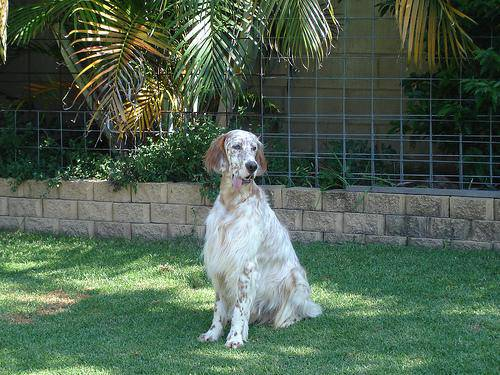

In [ ]:
from IPython.display import display, Image
Image("/content/test/0012a730dfa437f5f3613fb75efcd4ce.jpg")

In [ ]:
len(train_data_path), len(file_paths)

(15, 10222)

In [ ]:
#load train data
test_data_path = '/content/test/' #make path of train file
test_file_paths = [test_data_path + f + '.jpg' for f in breeds['id']] #create pathname from image ID
print(test_file_paths[:3]) #check first few file names

#check number of file name equal number of actual image
#print(str(np.where(len(os.listdir(test_data_path)) == len(test_file_paths), 'Equal length', 'File name count doesn\'t match image count')))

['/content/test/000bec180eb18c7604dcecc8fe0dba07.jpg', '/content/test/001513dfcb2ffafc82cccf4d8bbaba97.jpg', '/content/test/001cdf01b096e06d78e9e5112d419397.jpg']


In [ ]:
len(test_data_path), len(test_file_paths)

(14, 10222)

##Load labels

Prepare labels for tensor flow format using 1-hot encoding idea


In [ ]:
labels = breeds['breed'].to_numpy() #change breeds df to numpy array
print(labels[:120]) #show first 5 labels
#check number of labels equal actual number of breeds
print(str(np.where(len(labels) == len(file_paths), 'Equal length', 'Label count doesn\'t match breed count')))

In [ ]:
#convert labels from string data to numbers so model can understand
unique_breeds = np.unique(labels)
print(len(unique_breeds))

#turn labels into boolean array, each array mark True at right breed, False otherwise
#create total of 120 arrays
boolean_labels = [l == np.array(unique_breeds) for l in labels]
print(boolean_labels[0])

120
[False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


In [ ]:
print(boolean_labels[0].astype(int)) #we will convert boolean array to binary array later; now imagine it as this

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


##Create validation, test, train sets


In [ ]:
#separate data into predictors and labels
X = file_paths
y = boolean_labels
print('Image and label lengths:', len(X), ',', len(y)) #number of images/labels for images

#split into training and validation
X_train, X_val, y_train, y_val = train_test_split(X[:len(X)], y[:len(y)], test_size = 0.2, random_state = 1)
print('Train and validation lengths:', len(X_train), len(y_train), len(X_val), len(y_val))

Image and label lengths: 10222 , 10222
Train and validation lengths: 8177 8177 2045 2045


##Process images by turning it to tensor format

In [ ]:
#convert image to numpy array
image = imread(file_paths[0]) #read in an image
print(image.shape)
print(tf.constant(image)[:2]) #convert to tensor object

NameError: name 'imread' is not defined

In [ ]:
image_size = 224 #set an initial image size; in our case, we use image size of 224
#function to process an image when given the image path
def process_image(path):
  image = tf.io.read_file(path) #read in image file
  image = tf.image.decode_jpeg(image, channels = 3) #decode jpg image to tensor numerical with 3 channels
  image = tf.image.convert_image_dtype(image, tf.float32) #scale color channel values
  image = tf.image.resize(image, size = [image_size,image_size]) #resize image to target tensor flow size
  return image

#function to return the image and label, when given the image path and label
def get_image_label(path, label): return process_image(path), label

##Create data batch

Since the image data is computational intensive and we encounter a fairly large dataset of 10,000 images, let spit the test, valid, train sets to smaller batches so the sake of running time and GPU

In [ ]:
#function to split data to batches
def make_batches(X, y=None, batch_size = 32, valid_data = False, test_data = False):
  if test_data: data_batch = tf.data.Dataset.from_tensor_slices((tf.constant(X))).map(process_image).batch(batch_size)
  elif valid_data: data_batch = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))).map(get_image_label).batch(batch_size)
  else: data_batch = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))).shuffle(buffer_size = len(X)).map(get_image_label).batch(batch_size)
  return data_batch

In [ ]:
#create train and valid data batches
train_data = make_batches(X_train, y_train, 32, False, False) #default values
val_data = make_batches(X_val, y_val, 32, True, False)
test_data = make_batches(test_file_paths, test_data=True)
#look at those new batches
print(train_data.element_spec, val_data.element_spec)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)) (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))


##Take a look at data

In [ ]:
#function to plot images with their breed names
def show_images(images, labels):
  plt.figure(figsize = (10,10))
  for ix in range(25):
    ax = plt.subplot(5, 5, ix+1)
    plt.imshow(images[ix])
    plt.title(unique_breeds[labels[ix].argmax()])
    plt.axis('off')

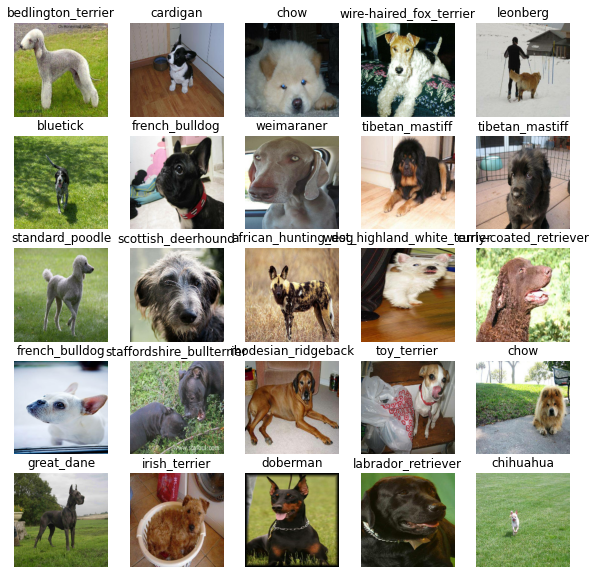

In [ ]:
#plot some train set images
train_images, train_labels = next(train_data.as_numpy_iterator())
show_images(train_images, train_labels)

##Now, create and train model

Prepare data for transfer learning

In [ ]:
in_shape = [None, image_size, image_size, 3] #initialize default settings for the following functuon
out_shape = len(unique_breeds)
url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4' #transfer learning method MobileNet
#function to create the transfer learning model
def make_model(input_shape = in_shape, output_shape = out_shape, model_url = url):
  #model.layers[:-4]: layer.trainable = False
  model = tf.keras.Sequential([hub.KerasLayer(url),
                             tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(units = output_shape, activation = 'softmax')])
  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
  model.build(input_shape)
  return model

#function to train the model
def train_model():
  model = make_model() #create a model
  model.fit(x = train_data, epochs = 10, validation_data = val_data, validation_freq = 1) #fit model to data, passing callbacks created; check val metrics
  return model

In [ ]:
basemodel = train_model()
print(basemodel.summary())

Epoch 1/10
180/256 [====================>.........] - ETA: 1:58 - loss: 2.1333 - accuracy: 0.5227

KeyboardInterrupt: ignored

In [ ]:

image_size

224

In [ ]:
newmodel = models.Sequential()
newmodel = tf.keras.Model(in_shape, out_shape)
newmodel = model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
newmode.summary()
history = newmodel.fit(x = train_data, epochs = 10, validation_data = test_data)

ValueError: ignored

In [ ]:
model1 = models.Sequential()


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.tf.keras.applications.mobilenet_v2.preprocess_input

AttributeError: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##Make a TensorBoard logs to look cool

In [ ]:
#load extension
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
#create a function to build a TensorBoard callback
def create_tensorboard_callback():
  #create a log directory for storing TensorBoard logs; make it so the logs get tracked whenever we run an experiment
  log_dir = os.path.join('logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  return tf.keras.callbacks.TensorBoard(log_dir)

##Get predicted breed by model

In [ ]:
predictions = model.predict(val_data, verbose = 1) #get preds
print(predictions.shape)
print(predictions)

64/64 [==============================] - 5s 81ms/step
(2045, 120)
[[3.6388991e-04 1.3646131e-06 1.7336978e-06 ... 1.8879429e-07
  8.0650146e-08 3.3155742e-01]
 [2.7880245e-10 9.9376951e-10 9.9991727e-01 ... 1.5790734e-07
  9.0740961e-09 9.6314725e-09]
 [4.9700919e-08 7.2322764e-06 6.8555779e-09 ... 2.9613525e-07
  6.3505787e-08 7.7709283e-11]
 ...
 [6.1672586e-07 9.5431709e-12 1.1903379e-08 ... 2.9056483e-07
  1.1483023e-10 1.1719885e-08]
 [3.5772176e-09 3.6784250e-08 1.1183605e-09 ... 9.7134034e-07
  1.1655729e-04 6.8325747e-08]
 [2.2521521e-10 1.3447494e-02 2.1445403e-09 ... 1.0945603e-04
  8.3761533e-06 1.0744865e-06]]


In [ ]:
#function to get label predictions
def get_pred(prediction_probs): return unique_breeds[np.argmax(prediction_probs)]

In [ ]:
pred_breed = get_pred(predictions[99]) #get some predictions
print(pred_breed)

dingo


In [ ]:
#unbatch the validation data
val_images, val_labels = unbatch(val_data)
print(val_images[0])
print(val_labels[0])

In [ ]:
#function to plot predictions
def plot_prediction(prediction_probs, labels, images, n):
  pred_prob, true_label, image = prediction_probs[n], labels[n], images[n]
  pred_breed = get_pred(pred_prob)
  plt.show(images[n])
  plt.xticks([])
  plt.yticks([])
  pred_label = get_pred(prediction_probs[n])
  color = str(np.where(pred_label == labels[n], 'blue', 'red'))
  plt.title('{} {:2.0f}% ({})'.format(pred_label,
                                      np.max(prediction_probs[n]) * 100, labels[n]),
            color = color)

In [ ]:
plot_prediction(prediction_probs = predictions, labels = val_labels, images = val_images, n = 1)

In [ ]:
#function to unbatch the data batch
def unbatch(data):
  images, labels = ([] for i in range(2))
  for image,label in data.unbatch().as_numpy_iterator(): #loop through unbatched data
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

#Train model on train set

In [ ]:
full_data = make_batches(X,y)

In [ ]:
full_model = train_model()

#Evaluate model

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()